<a id='1'></a>
# Import packages

In [1]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf
import random
import simplejson as json

Using TensorFlow backend.


In [2]:
import os
import cv2
import glob
import time
import numpy as np
from pathlib import PurePath, Path
from IPython.display import clear_output
from utils import stack_images
import matplotlib.pyplot as plt
%matplotlib inline

<a id='4'></a>
# Config

In [3]:
#K.set_learning_phase(1)
#K.set_learning_phase(0) # set to 0 in inference phase

In [4]:
# Number of CPU cores
num_cpus = os.cpu_count()

# Input/Output resolution
RESOLUTION = 64 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize =2
assert (batchSize != 1 and batchSize % 2 == 0) , "batchSize should be an even number."

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = True 

# Use eye-aware training
# require images generated from prep_binary_masks.ipynb
use_bm_eyes = True

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

da_config = {
    "prob_random_color_match": prob_random_color_match,
    "use_da_motion_blur": use_da_motion_blur,
    "use_bm_eyes": use_bm_eyes
}

In [5]:
# Path to training images
img_dirA = './faceA'
img_dirB = './faceB'
img_dirA_bm_eyes = "./binary_masks/faceA_eyes"
img_dirB_bm_eyes = "./binary_masks/faceB_eyes"

# Path to saved model weights
models_dir = "./models"

In [6]:
# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "instancenorm" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "standard" # standard, lite

In [7]:
# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN" # "mixup_LSGAN" or "relativistic_avg_LSGAN"
loss_config['use_PL'] = False
loss_config["PL_before_activ"] = False
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = True

<a id='5'></a>
# Define models

In [8]:
from networks.faceswap_gan_model import FaceswapGANModel

In [21]:
model = FaceswapGANModel(**arch_config)

<a id='6'></a>
# Load Model Weights

Weights file names:
```python
encoder.h5, decoder_A.h5, deocder_B.h5, netDA.h5, netDB.h5
```

In [22]:
model.load_weights(path=models_dir)

Model weights files are successfully loaded.


### The following cells are for training, skip to [transform_face()](#tf) for inference.

# Define Losses and Build Training Functions

TODO: split into two methods

In [23]:
# https://github.com/rcmalli/keras-vggface

from keras_vggface.vggface import VGGFace

# VGGFace ResNet50
vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
print("vggface summary")
#vggface.summary()
#for layer in vggface.layers:
#    print(layer.name)
#print(len(vggface.layers))

model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])

vggface summary


In [24]:
model.build_train_functions(loss_weights=loss_weights, **loss_config)

negG1 y G2 shape (None, 64, 64, 3)
real1 shape (?, 64, 64, 3)
fake2 shape (?, 64, 64, 4)
fake2_alpha shape (?, 64, 64, 1)
fake2 b shape (?, 64, 64, 3)
negG1 y G2 shape (None, 64, 64, 3)
real1 shape (?, 64, 64, 3)
fake2 shape (?, 64, 64, 4)
fake2_alpha shape (?, 64, 64, 1)
fake2 b shape (?, 64, 64, 3)


<a id='9'></a>
# DataLoader

In [25]:
from data_loader.data_loader import DataLoader

# Visualizer

TODO: write a Visualizer class

In [26]:
from utils import showG, showG_mask, showG_eyes

<a id='10'></a>
# Start Training


In [27]:
# Create ./models directory
Path(f"models").mkdir(parents=True, exist_ok=True)

In [28]:
# Get filenames
train_A = glob.glob(img_dirA+"/*.*")
print('imagedir',img_dirA)
print(train_A)
train_B = glob.glob(img_dirB+"/*.*")

train_AnB = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

if use_bm_eyes:
    assert len(glob.glob(img_dirA_bm_eyes+"/*.*")), "No binary mask found in " + str(img_dirA_bm_eyes)
    assert len(glob.glob(img_dirB_bm_eyes+"/*.*")), "No binary mask found in " + str(img_dirB_bm_eyes)
    print("len img_dirA_bm_eyes",len(img_dirA_bm_eyes),img_dirA_bm_eyes)
    print("len train_A",len(train_A))
    assert len(glob.glob(img_dirA_bm_eyes+"/*.*")) == len(train_A), \
    "Number of faceA images does not match number of their binary masks. Can be caused by any none image file in the folder."
    assert len(glob.glob(img_dirB_bm_eyes+"/*.*")) == len(train_B), \
    "Number of faceB images does not match number of their binary masks. Can be caused by any none image file in the folder."

imagedir ./faceA
['./faceA/frame606face0.jpg', './faceA/frame312face0.jpg', './faceA/frame438face0.jpg', './faceA/frame138face0.jpg', './faceA/frame324face0.jpg', './faceA/frame414face0.jpg', './faceA/frame534face0.jpg', './faceA/frame126face0.jpg', './faceA/frame186face0.jpg', './faceA/frame270face0.jpg', './faceA/frame108face0.jpg', './faceA/frame300face0.jpg', './faceA/frame102face0.jpg', './faceA/frame396face0.jpg', './faceA/frame42face0.jpg', './faceA/frame486face0.jpg', './faceA/frame612face0.jpg', './faceA/frame672face0.jpg', './faceA/frame150face0.jpg', './faceA/frame582face0.jpg', './faceA/frame378face0.jpg', './faceA/frame318face0.jpg', './faceA/frame60face0.jpg', './faceA/frame72face0.jpg', './faceA/frame132face0.jpg', './faceA/frame354face0.jpg', './faceA/frame456face0.jpg', './faceA/frame402face0.jpg', './faceA/frame54face0.jpg', './faceA/frame240face0.jpg', './faceA/frame594face0.jpg', './faceA/frame258face0.jpg', './faceA/frame654face0.jpg', './faceA/frame114face0.jpg', 

In [29]:
def show_loss_config(loss_config):
    for config, value in loss_config.items():
        print(f"{config} = {value}")

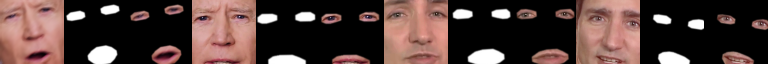

In [30]:
# Display random binary masks of eyes
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
_, tA, bmA = train_batchA.get_next_batch()
_, tB, bmB = train_batchB.get_next_batch()
typer="eyes"
number_it=random.randrange(0,10000)
showG_eyes(tA, tB, bmA, bmB, batchSize,typer,number_it)
del train_batchA, train_batchB

In [31]:
def reset_session(save_path):
    global model, vggface
    global train_batchA, train_batchB
    model.save_weights(path=save_path)
    del model
    del vggface
    del train_batchA
    del train_batchB
    K.clear_session()
    model = FaceswapGANModel(**arch_config)
    model.load_weights(path=save_path)
    vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
    model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
    train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes,
                              RESOLUTION, num_cpus, K.get_session(), **da_config)
    train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                              RESOLUTION, num_cpus, K.get_session(), **da_config)
    

gan_training = mixup_LSGAN
use_PL = True
PL_before_activ = False
use_mask_hinge_loss = False
m_mask = 0.0
lr_factor = 0.1
use_cyclic_loss = True
----------
[iter 300] Loss_DA: 0.114220 Loss_DB: 0.085245 Loss_GA: 2.797536 Loss_GB: 2.470004 time: 1334.034056
----------
Generator loss details:
[Adversarial loss]
GA: 0.1308 GB: 0.1452
[Reconstruction loss]
GA: 0.6799 GB: 0.5946
[Edge loss]
GA: 0.6860 GB: 0.5543
[Perceptual loss]
GA: 0.2285 GB: 0.2174
----------
Transformed (masked) results:


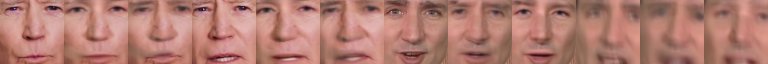

Masks:
Reconstruction results:


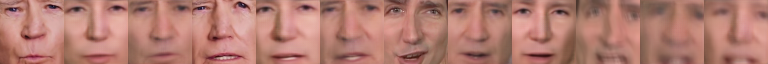

Model weights files have been saved to ./models.
printing TA


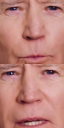

printing TB


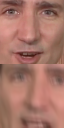

printing tA modelpath_A_ <keras.backend.tensorflow_backend.Function object at 0x7fd18d373a20>


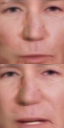

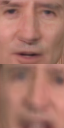

printing tB modelpath mask _B_


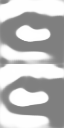

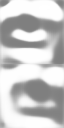

printing WA


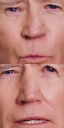

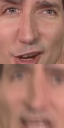

printing WA path_bgr_A_


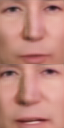

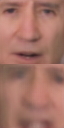

tA combined


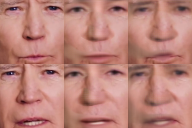

tB combined


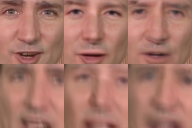

tA masks combined


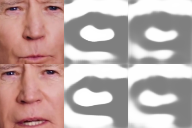

tB masks combined


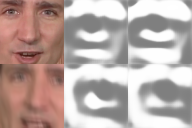

WA bgr combined


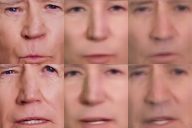

WB bgr combined


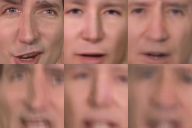

Model weights files have been saved to ./models/backup_iter300.
Creating previews
model dir:  models
Saving progress
Plot progress.
Plot done
[epoch 0][iter 301] Loss_DA: 0.171845 Loss_DB: 0.038392 Loss_DA2: 2.755441 Loss_DB2: 2.386433 Loss_GA: 2.755441 Loss_GB: 2.386433 time: 1339523ms


In [32]:
# Start training
t0 = time.time()
import simplejson as json
from IPython.display import display
from PIL import Image

# This try/except is meant to resume training that was accidentally interrupted
try:
    gen_iterations
    print(f"Resume training from iter {gen_iterations}.")
except:
    gen_iterations = 0

errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 10
backup_iters = 50
TOTAL_ITERS = 300
#*****************************my code**************
def load_progress(thedir):
    try:
        progress = Path(thedir / 'progress.json')
        with progress.open() as f:
            progress = json.load(f)

        return progress
    except Exception as e:
        print("No progress data loaded.")
        print(e)
        p = dict(epoch=list(),
                 iterations=list(),
                 errDA=list(),
                 errDB=list(),
                 errDA2=list(),
                 errDB2=list(),
                 errGA=list(),
                 errGB=list())
        return p


model_dir = "models"
   # model_dir.mkdir(parents=True, exist_ok=True)

preview_dir = "previews"
  #  preview_dir.mkdir(parents=True, exist_ok=True)

print(model_dir)
progress = load_progress(model_dir)

if 'iterations' in progress and len(progress['iterations']) > 0:
    gen_iterations = progress['iterations'][-1] + 1
    print("Restarting from iteration {}".format(gen_iterations))
else:
    gen_iterations = 0

if 'epoch' in progress and len(progress['epoch']) > 0:
    epoch = progress['epoch'][-1]
else:
    epoch = 0



#*****************************my code**************
def save_models(thedir):
        print("Saving models")
        global encoder, decoder_A, decoder_B, decoder_AnB, decoder_type, decoder_common, decoder_A2, decoder_B2, netD_code, base_model
        encoder.save_weights(str(thedir / "encoder.h5"))
        decoder_A.save_weights(str(thedir / "decoder_A.h5"))
        decoder_B.save_weights(str(thedir / "decoder_B.h5"))
        if base_model == "VAE-GAN" or base_model == "GAN":
            decoder_AnB.save_weights(str(thedir / "decoder_AnB.h5"))
            if decoder_type == 1:
                decoder_common.save_weights(str(thedir / "decoder_common.h5"))
            elif decoder_type == 2:
                decoder_A2.save_weights(str(thedir / "decoder_A2.h5"))
                decoder_B2.save_weights(str(thedir / "decoder_B2.h5"))
        netDA.save_weights(str(thedir / "netDA.h5"))
        netDB.save_weights(str(thedir / "netDB.h5"))
        netDA2.save_weights(str(thedir / "netDA2.h5"))
        netDB2.save_weights(str(thedir / "netDB2.h5"))
        if base_model == "XGAN":
            netD_code.save_weights("models/netD_code.h5")

def save_progress(thedir, progress):
        print("Saving progress")
        progress_file = Path(thedir + '/progress.json')
        with progress_file.open('w') as f:
            j = json.dumps(progress, ensure_ascii=False)
            f.write(j)

def plot_progress(thedir, progress):
        print("Plot progress.")
        fig = plt.figure(figsize=(20, 10))
        plt.cla()
        ax1 = fig.gca()
        ax2 = ax1.twinx()

        ax1.plot(progress['errDA'], color='lightblue')
        ax1.plot(progress['errDB'], color='lightgreen')

        if 'errDA2' in progress:
            ax1.plot(progress['errDA2'], color='lightblue')

        if 'errDB2' in progress:
            ax1.plot(progress['errDB2'], color='lightgreen')

        ax2.plot(progress['errGA'], color='yellow')
        ax2.plot(progress['errGB'], color='red')

        plt.savefig(str(thedir + '/progress.png'))
        plt.clf()
        plt.close()
        print("Plot done")

def showG_savefile(test_A, test_B, path_A, path_B, filename):
    global batchSize
   
    figure_A = np.stack([
            test_A,
            np.squeeze(np.array([path_A([test_A[i:i + 1]]) for i in range(test_A.shape[0])])),
            np.squeeze(np.array([path_B([test_A[i:i + 1]]) for i in range(test_A.shape[0])])),
        ], axis=1)
    figure_B = np.stack([
            test_B,
            np.squeeze(np.array([path_B([test_B[i:i + 1]]) for i in range(test_B.shape[0])])),
            np.squeeze(np.array([path_A([test_B[i:i + 1]]) for i in range(test_B.shape[0])])),
        ], axis=1)

    figure = np.concatenate([figure_A, figure_B], axis=0)
    figure = figure.reshape((4, batchSize // 2) + figure.shape[1:])
    figure = stack_images(figure)
    figure = np.clip((figure + 1) * 255 / 2, 0, 255).astype('uint8')
    figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)    
  #  display(Image.fromarray(figure))
    result=Image.fromarray(figure)
  #  fname = f"./results/{typer}it{str(iterations)}.jpg"
    result.save(filename)

def showG_savefilecombined(test_A, path_A, path_B, filename):
    global batchSize
   
    figure_A = np.stack([
            test_A,
            np.squeeze(np.array([path_A([test_A[i:i + 1]]) for i in range(test_A.shape[0])])),
            np.squeeze(np.array([path_B([test_A[i:i + 1]]) for i in range(test_A.shape[0])])),
        ], axis=1)


    figure_A = stack_images(figure_A)
    figure_A = np.clip((figure_A + 1) * 255 / 2, 0, 255).astype('uint8')
    figure_A = cv2.cvtColor(figure_A, cv2.COLOR_BGR2RGB)    
    display(Image.fromarray(figure_A))
    result=Image.fromarray(figure_A)
  #  fname = f"./results/{typer}it{str(iterations)}.jpg"
    result.save(filename)


def showG_saveindividualfile(test_A, filename):
    global batchSize

    
    
    figuretoshow= np.stack([test_A],axis=1)
    
    figuretoshow = stack_images(figuretoshow)
    figuretoshow = np.clip((figuretoshow + 1) * 255 / 2, 0, 255).astype('uint8')
    figuretoshow = cv2.cvtColor(figuretoshow, cv2.COLOR_BGR2RGB)    
    display(Image.fromarray(figuretoshow))
    result=Image.fromarray(figuretoshow)
  #  fname = f"./results/{typer}it{str(iterations)}.jpg"
    result.save(filename)

def showG_saveindividualfilemask(test_A,path_A, filename):
    global batchSize

    
    
    figuretoshow= np.stack([np.squeeze(np.array([path_A([test_A[i:i+1]]) for i in range(test_A.shape[0])]))],axis=1)
    
    figuretoshow = stack_images(figuretoshow)
    figuretoshow = np.clip((figuretoshow + 1) * 255 / 2, 0, 255).astype('uint8')
    figuretoshow = cv2.cvtColor(figuretoshow, cv2.COLOR_BGR2RGB)    
    display(Image.fromarray(figuretoshow))
    result=Image.fromarray(figuretoshow)
  #  fname = f"./results/{typer}it{str(iterations)}.jpg"
    result.save(filename)
              
    
            
global train_batchA, train_batchB
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)

def schedule_training_functions(gen_iterations, display_iters, TOTAL_ITERS):
    errGA_sum = errGB_sum = errDA_sum = errDB_sum  = errDA_code_sum = errDB_code_sum = 0
    while gen_iterations <= TOTAL_ITERS: 

        # Loss function automation
        if gen_iterations == (TOTAL_ITERS//5 - display_iters//2):
            clear_output()
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = False
            loss_config['m_mask'] = 0.0
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Done.")
        elif gen_iterations == (TOTAL_ITERS//5 + TOTAL_ITERS//10 - display_iters//2):
            clear_output()
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = True
            loss_config['m_mask'] = 0.5
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Complete.")
        elif gen_iterations == (2*TOTAL_ITERS//5 - display_iters//2):
            clear_output()
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = True
            loss_config['m_mask'] = 0.2
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Done.")
        elif gen_iterations == (TOTAL_ITERS//2 - display_iters//2):
            clear_output()
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = True
            loss_config['m_mask'] = 0.4
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Done.")
        elif gen_iterations == (2*TOTAL_ITERS//3 - display_iters//2):
            clear_output()
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = False
            loss_config['m_mask'] = 0.
            loss_config['lr_factor'] = 0.3
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Done.")
        elif gen_iterations == (8*TOTAL_ITERS//10 - display_iters//2):
            clear_output()
            model.decoder_A.load_weights("models/decoder_B.h5") # swap decoders
            model.decoder_B.load_weights("models/decoder_A.h5") # swap decoders
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = True
            loss_config['m_mask'] = 0.1
            loss_config['lr_factor'] = 0.3
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Done.")
        elif gen_iterations == (9*TOTAL_ITERS//10 - display_iters//2):
            clear_output()
            loss_config['use_PL'] = True
            loss_config['use_mask_hinge_loss'] = False
            loss_config['m_mask'] = 0.0
            loss_config['lr_factor'] = 0.1
            reset_session(models_dir)
            print("Building new loss funcitons...")
            show_loss_config(loss_config)
            model.build_train_functions(loss_weights=loss_weights, **loss_config)
            print("Done.")

        if gen_iterations == 5:
            print ("working.")

        # Train dicriminators for one batch
        data_A = train_batchA.get_next_batch()
        data_B = train_batchB.get_next_batch()
        errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
        errDA_sum +=errDA[0]
        errDB_sum +=errDB[0]

        # Train generators for one batch
        data_A = train_batchA.get_next_batch()
        data_B = train_batchB.get_next_batch()
        errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
        errGA_sum += errGA[0]
        errGB_sum += errGB[0]
        for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
            errGAs[k] += errGA[i]
            errGBs[k] += errGB[i]
        gen_iterations+=1

        # Visualization
        if gen_iterations % display_iters == 0:
            clear_output()

            # Display loss information
            show_loss_config(loss_config)
            print("----------") 
            print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
            % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
               errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
            print("----------") 
            print("Generator loss details:")
            print(f'[Adversarial loss]')  
            print(f'GA: {errGAs["adv"]/display_iters:.4f} GB: {errGBs["adv"]/display_iters:.4f}')
            print(f'[Reconstruction loss]')
            print(f'GA: {errGAs["recon"]/display_iters:.4f} GB: {errGBs["recon"]/display_iters:.4f}')
            print(f'[Edge loss]')
            print(f'GA: {errGAs["edge"]/display_iters:.4f} GB: {errGBs["edge"]/display_iters:.4f}')
            if loss_config['use_PL'] == True:
                print(f'[Perceptual loss]')
                try:
                    print(f'GA: {errGAs["pl"][0]/display_iters:.4f} GB: {errGBs["pl"][0]/display_iters:.4f}')
                except:
                    print(f'GA: {errGAs["pl"]/display_iters:.4f} GB: {errGBs["pl"]/display_iters:.4f}')

            # Display images
            print("----------") 
            wA, tA, _ = train_batchA.get_next_batch()
            wB, tB, _ = train_batchB.get_next_batch()
            print("Transformed (masked) results:")
            typer="masked"
            showG(tA, tB, model.path_A, model.path_B,batchSize,typer,gen_iterations)   
            print("Masks:")
            typer="masks"
            #showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize,typer,gen_iterations)  
            print("Reconstruction results:")
            typer="reconstruction"
            showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize,typer,gen_iterations)           
            errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
            for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
                errGAs[k] = 0
                errGBs[k] = 0

            # Save models
            model.save_weights(path=models_dir)
            
#*************************My code**********************************************                          
            fn = str(preview_dir + '/mypreview_{:06d}_masked.png'.format(gen_iterations))
            showG_savefile(tA, tB, model.path_A, model.path_B, fn)
           
            fn = str(preview_dir + '/mypreview_{:06d}_raw.png'.format(gen_iterations))
            showG_savefile(wA, wB, model.path_bgr_A, model.path_bgr_B, fn)

            fn = str(preview_dir + '/mypreview_{:06d}_mask.png'.format(gen_iterations))
            showG_savefile(tA, tB, model.path_mask_A, model.path_mask_B, fn)              

 #****************************************************************************************                         
            print("printing TA")
            fn2 = str(preview_dir + '/TA_{:06d}.png'.format(gen_iterations))              
            showG_saveindividualfile(tA,fn2)
            
            print("printing TB")
            fn2 = str(preview_dir + '/tB_{:06d}.png'.format(gen_iterations))              
            showG_saveindividualfile(tB,fn2)
                          
            print("printing tA modelpath_A_",model.path_A)

            fn2 = str(preview_dir + '/tA_modelpath_A_{:06d}.png'.format(gen_iterations))              
            showG_saveindividualfilemask(tA,model.path_A,fn2)
                          
                                  
            fn2 = str(preview_dir + '/tB_modelpath_B_{:06d}.png'.format(gen_iterations))              
            showG_saveindividualfilemask(tB, model.path_B,fn2)
                                                    
            print("printing tB modelpath mask _B_")
                          
            fn2 = str(preview_dir + '/tA_path_mask_A_{:06d}_mask.png'.format(gen_iterations))              
            showG_saveindividualfilemask(tA,model.path_mask_A,fn2)
                                      
            fn2 = str(preview_dir + '/tB_path_mask_B_{:06d}_mask.png'.format(gen_iterations))              
            showG_saveindividualfilemask(tB, model.path_mask_B,fn2)
                          
            print("printing WA")

            fn2 = str(preview_dir + '/wA_{:06d}_wA.png'.format(gen_iterations))
            showG_saveindividualfile(wA,fn2)
           
            fn2 = str(preview_dir + '/wB_{:06d}_wB.png'.format(gen_iterations))
            showG_saveindividualfile(wB, fn2)
                          
            print("printing WA path_bgr_A_")
                          
            fn2 = str(preview_dir + '/wA_path_bgr_A_{:06d}_raw.png'.format(gen_iterations))              
            showG_saveindividualfilemask(wA,model.path_bgr_A,fn2)
                                      
            fn2 = str(preview_dir + '/wB_path_bgr_B_{:06d}_raw.png'.format(gen_iterations))              
            showG_saveindividualfilemask(wB, model.path_bgr_B,fn2)

            print("tA combined")
            fn2 = str(preview_dir + '/tA_modelpath_A_and_B_{:06d}_masked.png'.format(gen_iterations)) 
            showG_savefilecombined(tA,model.path_A,model.path_B,fn2)             

            print("tB combined")
            fn2 = str(preview_dir + '/tB_modelpath_A_and_B_{:06d}_masked.png'.format(gen_iterations)) 
            showG_savefilecombined(tB,model.path_A,model.path_B,fn2)             

            print("tA masks combined")
            fn2 = str(preview_dir + '/tA_modelpathmask_A_and_B_{:06d}_masked.png'.format(gen_iterations)) 
            showG_savefilecombined(tA,model.path_mask_A, model.path_mask_B,fn2)             

            print("tB masks combined")
            fn2 = str(preview_dir + '/tB_modelpathmask_A_and_B_{:06d}_masked.png'.format(gen_iterations)) 
            showG_savefilecombined(tB, model.path_mask_A, model.path_mask_B,fn2)             
                          
            print("WA bgr combined")
            fn2 = str(preview_dir + '/WA_bgr_A_and_B_{:06d}_masked.png'.format(gen_iterations)) 
            showG_savefilecombined(wA,model.path_bgr_A, model.path_bgr_B,fn2)             

                         
            print("WB bgr combined")
            fn2 = str(preview_dir + '/WB_bgr_A_and_B_{:06d}_masked.png'.format(gen_iterations)) 
            showG_savefilecombined(wB,model.path_bgr_A, model.path_bgr_B,fn2)             
                          

        # Backup models
        if gen_iterations % backup_iters == 0: 
            bkup_dir = f"{models_dir}/backup_iter{gen_iterations}"
            Path(bkup_dir).mkdir(parents=True, exist_ok=True)
            model.save_weights(path=bkup_dir)

    #*****************my code***********************************#


        if gen_iterations % display_iters != 0:
            print('[epoch %d][iter %d] Loss_DA: %f Loss_DB: %f Loss_DA2: %f Loss_DB2: %f Loss_GA: %f Loss_GB: %f time: %dms'
                  % (epoch, gen_iterations, errDA[0], errDB[0], errGA[0], errGB[0],
                     errGA[0], errGB[0], int(1000 * (time.time() - t0))))

            progress['epoch'].append(int(epoch))
            progress['iterations'].append(int(gen_iterations))
            progress['errDA'].append(float(errDA[0]))
            progress['errDB'].append(float(errDB[0]))
            progress['errGA'].append(float(errGA[0]))
            progress['errGB'].append(float(errGB[0]))
       #     progress['errGB'].append(float(errGB[0]))
            progress['base_model'] = loss_config["gan_training"]

            pass


        else:

        #    print('[epoch %d][iter %d] Loss_DA: %f Loss_DB: %f  Loss_GA: %f Loss_GB: %f time: %dms'
        #          % (
        #          epoch, gen_iterations, errDA_sum / display_iters, errDB_sum / display_iters, errGA_sum / display_iters,
        #          errGB_sum / display_iters, int(1000 * (time.time() - t0))))
        #     if base_model == "XGAN":
        #         print(
        #             'Loss_DA_code: %f Loss_DB_code: %f' % (errDA_code_sum / display_iters, errDB_code_sum / display_iters))

                # Show previews
            print("Creating previews")
        if gen_iterations % (5 * display_iters) == 0:
            print("model dir: ",model_dir)
      #      save_models(model_dir)
            save_progress(model_dir, progress)
            plot_progress(model_dir, progress)
                          
schedule_training_functions(gen_iterations, display_iters, TOTAL_ITERS)


Transformed (masked) results:


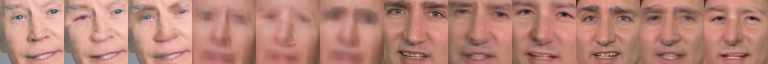

Masks:


TypeError: 'tuple' object is not callable

In [33]:
# Display random results

wA, tA, _ = train_batchA.get_next_batch()
wB, tB, _ = train_batchB.get_next_batch()
print("Transformed (masked) results:")
typer="transformed"
number_it=random.randrange(0,10000)
#showG(tA, tB, model.path_A, model.path_B, batchSize,typer,number_it)   
showG(tA,tB , model.path_A,model.path_B , batchSize,typer,number_it)   
print("Masks:")
typer="masks"
number_it=random.randrange(0,10000)
#showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize,typer,number_it)  

showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize,typer,number_it)  
print("Reconstruction results:")
typer="reconstruction"
number_it=random.randrange(0,10000)
showG(wA, wB, model.path_bgr_A, model.path_bgr_B,batchSize,typer, number_it) 
print("eyes")
showG_eyes(tA, tB, bmA, bmB, batchSize,typer,number_it)


<a id='tf'></a>
# Single Image Transformation

In [ ]:
from detector.face_detector import MTCNNFaceDetector
from converter.landmarks_alignment import *

In [ ]:
mtcnn_weights_dir = "./mtcnn_weights/"
fd = MTCNNFaceDetector(sess=K.get_session(), model_path=mtcnn_weights_dir)

In [ ]:
from converter.face_transformer import FaceTransformer
ftrans = FaceTransformer()
ftrans.set_model(model)

In [ ]:
# Read input image
input_img = plt.imread("./TEST_IMAGE2.jpg")[...,:3]

if input_img.dtype == np.float32:
    print("input_img has dtype np.float32 (perhaps the image format is PNG). Scale it to uint8.")
    input_img = (input_img * 255).astype(np.uint8)

In [ ]:
# Display input image
plt.imshow(input_img)

In [ ]:
# Display detected face
face, lms = fd.detect_face(input_img)
if len(face) == 1:
    x0, y1, x1, y0, _ = face[0]
    det_face_im = input_img[int(x0):int(x1),int(y0):int(y1),:]
    try:
        src_landmarks = get_src_landmarks(x0, x1, y0, y1, lms)
        tar_landmarks = get_tar_landmarks(det_face_im)
        aligned_det_face_im = landmarks_match_mtcnn(det_face_im, src_landmarks, tar_landmarks)
    except:
        print("An error occured during face alignment.")
        aligned_det_face_im = det_face_im
elif len(face) == 0:
    raise ValueError("Error: no face detected.")
elif len(face) > 1:
    print (face)
    raise ValueError("Error: multiple faces detected")
    
plt.imshow(aligned_det_face_im)

In [ ]:
# Transform detected face
result_img, result_rgb, result_mask = ftrans.transform(
                    aligned_det_face_im, 
                    direction="AtoB", 
                    roi_coverage=0.93,
                    color_correction="adain_xyz",
                    IMAGE_SHAPE=(RESOLUTION, RESOLUTION, 3)
                    )
try:
    result_img = landmarks_match_mtcnn(result_img, tar_landmarks, src_landmarks)
    result_rgb = landmarks_match_mtcnn(result_rgb, tar_landmarks, src_landmarks)
    result_mask = landmarks_match_mtcnn(result_mask, tar_landmarks, src_landmarks)
except:
    print("An error occured during face alignment.")
    pass

result_input_img = input_img.copy()
result_input_img[int(x0):int(x1),int(y0):int(y1),:] = result_mask.astype(np.float32)/255*result_rgb +\
(1-result_mask.astype(np.float32)/255)*result_input_img[int(x0):int(x1),int(y0):int(y1),:]

In [ ]:
# Show result face
plt.imshow(result_input_img[int(x0):int(x1),int(y0):int(y1),:])

In [ ]:
# Show transformed image before masking
plt.imshow(result_rgb)

In [ ]:
# Show alpha mask
plt.imshow(result_mask[..., 0])

In [ ]:
# Display interpolations before/after transformation
def interpolate_imgs(im1, im2):
    im1, im2 = map(np.float32, [im1, im2])
    out = [ratio * im1 + (1-ratio) * im2 for ratio in np.linspace(1, 0, 5)]
    out = map(np.uint8, out)
    return out

plt.figure(figsize=(15,8))
plt.imshow(np.hstack(interpolate_imgs(input_img, result_input_img)))